# Visualizing Defense

This notebook explores the defensive statistics available through the [stats.nba.com](https://stats.nba.com) API at the player level. The following explores the `playerdashptshotdefend` endoint through the `Player` class in the `py_ball` package.

In [1]:
from io import BytesIO
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Wedge
from PIL import Image
import time

from py_ball import player, league

HEADERS = {'Connection': 'close',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'Referer': 'stats.nba.com',
           'x-nba-stats-origin': 'stats',
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2)' + \
                         'AppleWebKit/537.36 (KHTML, like Gecko) ' + \
                         'Chrome/66.0.3359.117 Safari/537.36'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

In [2]:
league_id = '00' #NBA
player_id = '0'#'203954'
season = '2018-19'
team_id = '0'
game_id = '0'
per_mode = 'PerGame'

players = player.Player(headers=HEADERS,
                        endpoint='playerdashptshotdefend',
                        league_id=league_id,
                        player_id=player_id,
                        season=season,
                        team_id=team_id,
                        game_id=game_id,
                        per_mode=per_mode)

players.data.keys()

dict_keys(['DefendingShots'])

In [3]:
defense_df = pd.DataFrame(players.data['DefendingShots'])
defense_df.head(10)

,CLOSE_DEF_PERSON_ID,DEFENSE_CATEGORY,D_FGA,D_FGM,D_FG_PCT,FREQ,G,GP,NORMAL_FG_PCT,PCT_PLUSMINUS
0,1713,Overall,5.51,2.49,0.452,1.0,51,51,0.458,-0.006
1,1717,Overall,4.39,2.26,0.515,1.0,23,23,0.472,0.043
2,2037,Overall,3.69,1.91,0.518,1.0,45,45,0.445,0.073
3,2199,Overall,9.58,4.63,0.483,1.0,48,48,0.495,-0.012
4,2200,Overall,6.00,3.00,0.500,1.0,25,25,0.496,0.004
5,2225,Overall,4.04,1.73,0.429,1.0,45,45,0.425,0.003
6,2403,Overall,6.22,2.89,0.464,1.0,27,27,0.470,-0.006
7,2544,Overall,9.89,4.03,0.407,1.0,38,38,0.461,-0.054
8,2546,Overall,10.40,5.30,0.510,1.0,10,10,0.467,0.043
9,2548,Overall,7.84,3.32,0.423,1.0,44,44,0.445,-0.021


The `defense_df` shows examples for the data returned in the 2018-19 season. At this point, it'll be useful to define some of the features above.
- `CLOSE_DEF_PERSON_ID`: Unique identifier of the closest defender (Joel Embiid in this case due to our API call specifying his ID)
- `DEFENSE_CATEGORY`: Subsets of distance and shot type
- `D_FGA`: Field goal attempts per game for which the given player is the closest defender
- `D_FGM`: Field goals made per game for which the given player is the closest defender
- `D_FG_PCT`: Field goal percentage on shots for which the given player is the closest defender
- `FREQ`: Proportion of shots corresponding to the `DEFENSE_CATEGORY`
- `NORMAL_FG_PCT`: Expected field goal percentage of the shooters
- `PCT_PLUSMINUS`: `D_FG_PCT` - `NORMAL_FG_PCT`. A good definition of this value can be found [here](https://stats.nba.com/help/glossary/#diffpct)


# Visualizations

The unique `DEFENSE_CATEGORY` values do not easily lend themselves to clear data visualization. Ideally, these categories would be distinct (with the exception of `Overall`) so that each area could be isolated. However, the following will use `3 Pointers`, `2 Pointers`, `Less Than 10 Ft`, and `Less Than 6 Ft` to visualize defensive impact, with the understanding that the distance categories are subsets of the `2 Pointers` category. The following repeats the `draw_court` function from some of the other exploratory repos.

In [4]:
def draw_court():
    """ draw_court draws an NBA halfcourt
    
    Returns:
    
        fig (matplotlib.figure.Figure): Figure object visualizing
            an NBA court
        axis (matplotlib.axes._subplots.AxesSubplot): Axis object
            corresponding to fig
    """

    fig = plt.figure(figsize=(9, 9))
    axis = fig.add_subplot(111, aspect='auto')

    plt.plot([-250, 250], [-40, -40], 'k-') # endline
    plt.plot([-250, 250], [430, 430], 'k-') # halfcourt line
    plt.plot([-250, -250], [-40, 430], 'k-') # sideline
    plt.plot([250, 250], [-40, 430], 'k-') # sideline
    
    plt.plot([-30, 30], [-10, -10], 'k-') # backboard
    plt.plot([-60, -60], [-40, 150], 'k-') # lane
    plt.plot([60, 60], [-40, 150], 'k-') # lane
    plt.plot([-80, -80], [-40, 150], 'k-') # lane
    plt.plot([80, 80], [-40, 150], 'k-') # lane
    plt.plot([-80, 80], [150, 150], 'k-') # foul line

    plt.plot([220, 220], [-40, 90], 'k-') # 3pt straight
    plt.plot([-220, -220], [-40, 90], 'k-') # 3pt straight

    three_point = Arc((0, 0), width=237.5*2, height=237.5*2, theta1=22, theta2=158, linewidth=1.5)
    top_key = Arc((0, 150), width=60*2, height=60*2, theta1=0, theta2=180, linewidth=1.5)
    bottom_key = Arc((0, 150), width=60*2, height=60*2, theta1=180, theta2=360, linewidth=1.5, linestyle='--')
    basket = Arc((0, 0), width=7.5*2, height=7.5*2, theta1=0, theta2=360, linewidth=1.5)
    restricted = Arc((0, 7.5), width=40*2, height=40*2, theta1=0, theta2=180, linewidth=1.5)
    half_court = Arc((0, 430), width=60*2, height=60*2, theta1=180, theta2=360, linewidth=1.5)

    axis.add_patch(three_point)
    axis.add_patch(top_key)
    axis.add_patch(bottom_key)
    axis.add_patch(basket)
    axis.add_patch(restricted)
    axis.add_patch(half_court)

    plt.ylim(-50, 450)
    axis.set_aspect(1.0)
    plt.axis('off')

    return fig, axis

In [5]:
court, court_axis = draw_court()

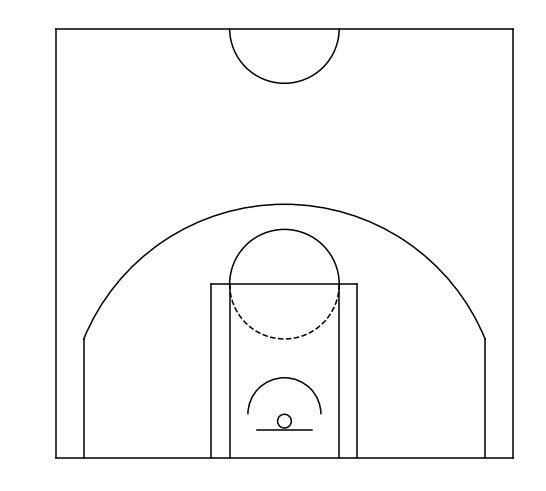

In [6]:
court

Player names are not available in the `playerdashptshotdefend` endpoint. To be able to add this information to the visualizatoins, the `commonallplayers` endpoint can be called.

In [7]:
player_info = league.League(headers=HEADERS,
                            endpoint='commonallplayers',
                            season='2018-19')

player_info_df = pd.DataFrame(player_info.data['CommonAllPlayers'])
player_info_df.head(5)

,DISPLAY_FIRST_LAST,DISPLAY_LAST_COMMA_FIRST,FROM_YEAR,GAMES_PLAYED_FLAG,PERSON_ID,PLAYERCODE,ROSTERSTATUS,TEAM_ABBREVIATION,TEAM_CITY,TEAM_CODE,TEAM_ID,TEAM_NAME,TO_YEAR
0,Alex Abrines,"Abrines, Alex",2016,Y,203518,alex_abrines,0,,,,0,,2018
1,Quincy Acy,"Acy, Quincy",2012,Y,203112,quincy_acy,0,,,,0,,2018
2,Jaylen Adams,"Adams, Jaylen",2018,Y,1629121,jaylen_adams,1,ATL,Atlanta,hawks,1610612737,Hawks,2018
3,Steven Adams,"Adams, Steven",2013,Y,203500,steven_adams,1,OKC,Oklahoma City,thunder,1610612760,Thunder,2018
4,Bam Adebayo,"Adebayo, Bam",2017,Y,1628389,bam_adebayo,1,MIA,Miami,heat,1610612748,Heat,2018


The `plot_defense` function below plots a heatmap onto the court visualization colored by `DIFF%`. This gives an illustration of the defensive abilities of a player when he is the closest defender. 

In [8]:
def plot_defense(player_id, defense_df):
    """ This function plots a heatmap colored by DIFF%,
    the difference between FG% when the player in player_id
    is the closest defender and the expected FG%

    @param player_id (int): Unique player identifier

    @param defense_df (DataFrame): pandas DataFrame of the
        data returned by the 'playerdashptshotdefend' endpoint
        of the stats.nba.com API

    Returns:

        court (matplotlib.figure.Figure): Figure object visualizing
            an NBA court with the defensive heatmap
        court_axis (matplotlib.axes._subplots.AxesSubplot): Axis object
            corresponding to fig
    """
    player_df = defense_df[defense_df['CLOSE_DEF_PERSON_ID']==player_id]
    player_name = player_info_df[player_info_df['PERSON_ID']==player_id]['DISPLAY_FIRST_LAST'].iloc[0]

    court, court_axis = draw_court()

    three_pointers = (player_df[player_df['DEFENSE_CATEGORY']=='3 Pointers']['PCT_PLUSMINUS'].iloc[0] + 0.1)/0.2
    two_pointers = (player_df[player_df['DEFENSE_CATEGORY']=='2 Pointers']['PCT_PLUSMINUS'].iloc[0] + 0.1)/0.2
    ten_ft = (player_df[player_df['DEFENSE_CATEGORY']=='Less Than 10 Ft']['PCT_PLUSMINUS'].iloc[0] + 0.1)/0.2
    six_ft = (player_df[player_df['DEFENSE_CATEGORY']=='Less Than 6 Ft']['PCT_PLUSMINUS'].iloc[0] + 0.1)/0.2
    
    cmap = matplotlib.cm.get_cmap('coolwarm')

    six_area = Wedge((0, 0), r=60, theta1=0, theta2=180, color=cmap(six_ft), alpha=0.5)
    ten_area = Wedge((0, 0), r=100, width=40, theta1=0, theta2=180, color=cmap(ten_ft), alpha=0.5)
    two_pt_area = Wedge((0, 0), r=237.5, width=137.5, theta1=22, theta2=158, color=cmap(two_pointers), alpha=0.5)
    three_pt_area = Wedge((0, 0), r=267.5, width=30, theta1=22, theta2=158, color=cmap(three_pointers), alpha=0.5)
    court_axis.add_patch(six_area)
    court_axis.add_patch(ten_area)
    court_axis.add_patch(two_pt_area)
    court_axis.add_patch(three_pt_area)

    x = np.arange(-220, -94, 0.01)
    y = [90 - ((xx+220)*0.4) - 2.05 for xx in x]
    court_axis.fill_between(x, [0]*len(x), y, facecolor=cmap(two_pointers), alpha=0.5)

    x = np.arange(94, 220, 0.01)
    y = [39.6 + ((xx-94)*0.4) - 2.05 for xx in x]
    court_axis.fill_between(x, [0]*len(x), y, facecolor=cmap(two_pointers), alpha=0.5)
    
    x = np.arange(-250, -220, 0.01)
    y = [100 - ((xx+250)*0.4) for xx in x]
    court_axis.fill_between(x, [0]*len(x), y, facecolor=cmap(three_pointers), alpha=0.5)

    x = np.arange(220, 250, 0.01)
    y = [88 + ((xx-220)*0.4) for xx in x]
    court_axis.fill_between(x, [0]*len(x), y, facecolor=cmap(three_pointers), alpha=0.5)

    cax, _ = matplotlib.colorbar.make_axes(court_axis)
    norm = matplotlib.colors.Normalize(vmin=-0.1, vmax=0.1)
    cb1 = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap,
                                           norm=norm)

    court_axis.set_title(player_name + ' DIFF%', fontsize=14)
    cb1.set_label('DIFF%', fontsize=14)

    plt.close()

    return court, court_axis

In [9]:
def_court, def_court_axis = plot_defense(203954, defense_df)

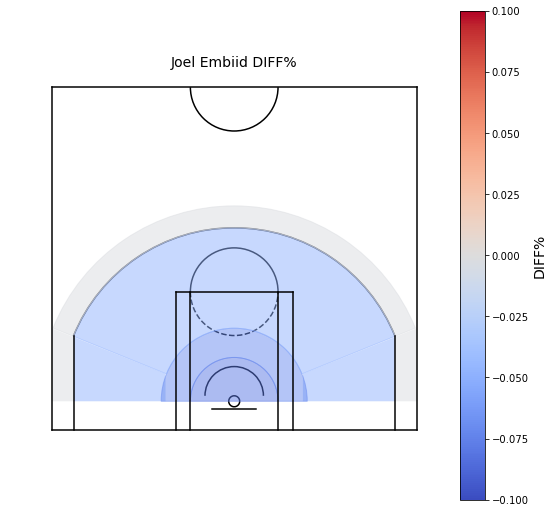

In [10]:
def_court

## Exploration
- Add either the `D_FG_PCT` or `DIFF%` to each section of the heatmap above.
- Pull in multiple seasons of defensive data and plot year-over-year trendlines for `DIFF%` for one of the areas defined in `DEFENSE_CATEGORY`. Is this metric stable year-to-year?